<style>
div.text_cell_render {
    font-family: "Times New Roman", serif;
}
</style>

# What this Jupyter notebook does

This Jupyter notebook contains the math and Python for the following [LinkedIn post from 11/11/25](https://www.linkedin.com/posts/activity-7394018994925625344-ZHAI?utm_source=share&utm_medium=member_desktop&rcm=ACoAAFmtAVkBHB1hBzAhZv0QLtcY55Q_sKSUiMk).

# The 11/11/25 LinkedIn Post

🚨 How pervasive is an emergent fraud vector? 🚨

You have uncovered a new way that criminals are committing fraud, with 3 unrelated cases out of 1,000 transactions. How pervasive could this new fraud type be? Can answers from generative AI or a Stats 101 webpage be trusted? 🤔

Binomial methods give more accurate confidence bounds than normal approximations commonly suggested by AI or beginner stats. Here’s a comparison for 99% confidence:

✅ Binomial: You can be 99% confident that the new fraud vector accounts for < 1.0% of transactions.

❌ AI/Stats 101 might say:

- “The fraud rate is 0.3% ± 0.4% with 99% confidence.”
- “The fraud rate is 0.3% ± 0.3%.” (because you didn’t know you could specify the confidence level and your gen AI / webpage defaults to 95%), and even:
- “Three fraud cases is too small for statistical significance.”

🥀 Best case with “AI/Stats 101”, you walk away thinking you can be 99% confident that the emergent fraud rate is at most 0.7%. But “AI/Stats 101” has given you false hope. The true bound with 99% confidence is 1.0%.

Maybe this small a difference (0.7% vs 1.0%) doesn’t matter to you. But I’m guessing you’d rather have the right answer when it can be delivered just as quickly (as in this case).

Visualizing these differences for 1–7 fraud cases in 1,000 transactions highlights the gap—and the value of proper stats. 📊

#FraudDetection #Statistics #DataScience #RiskAnalytics #EmergentFraud

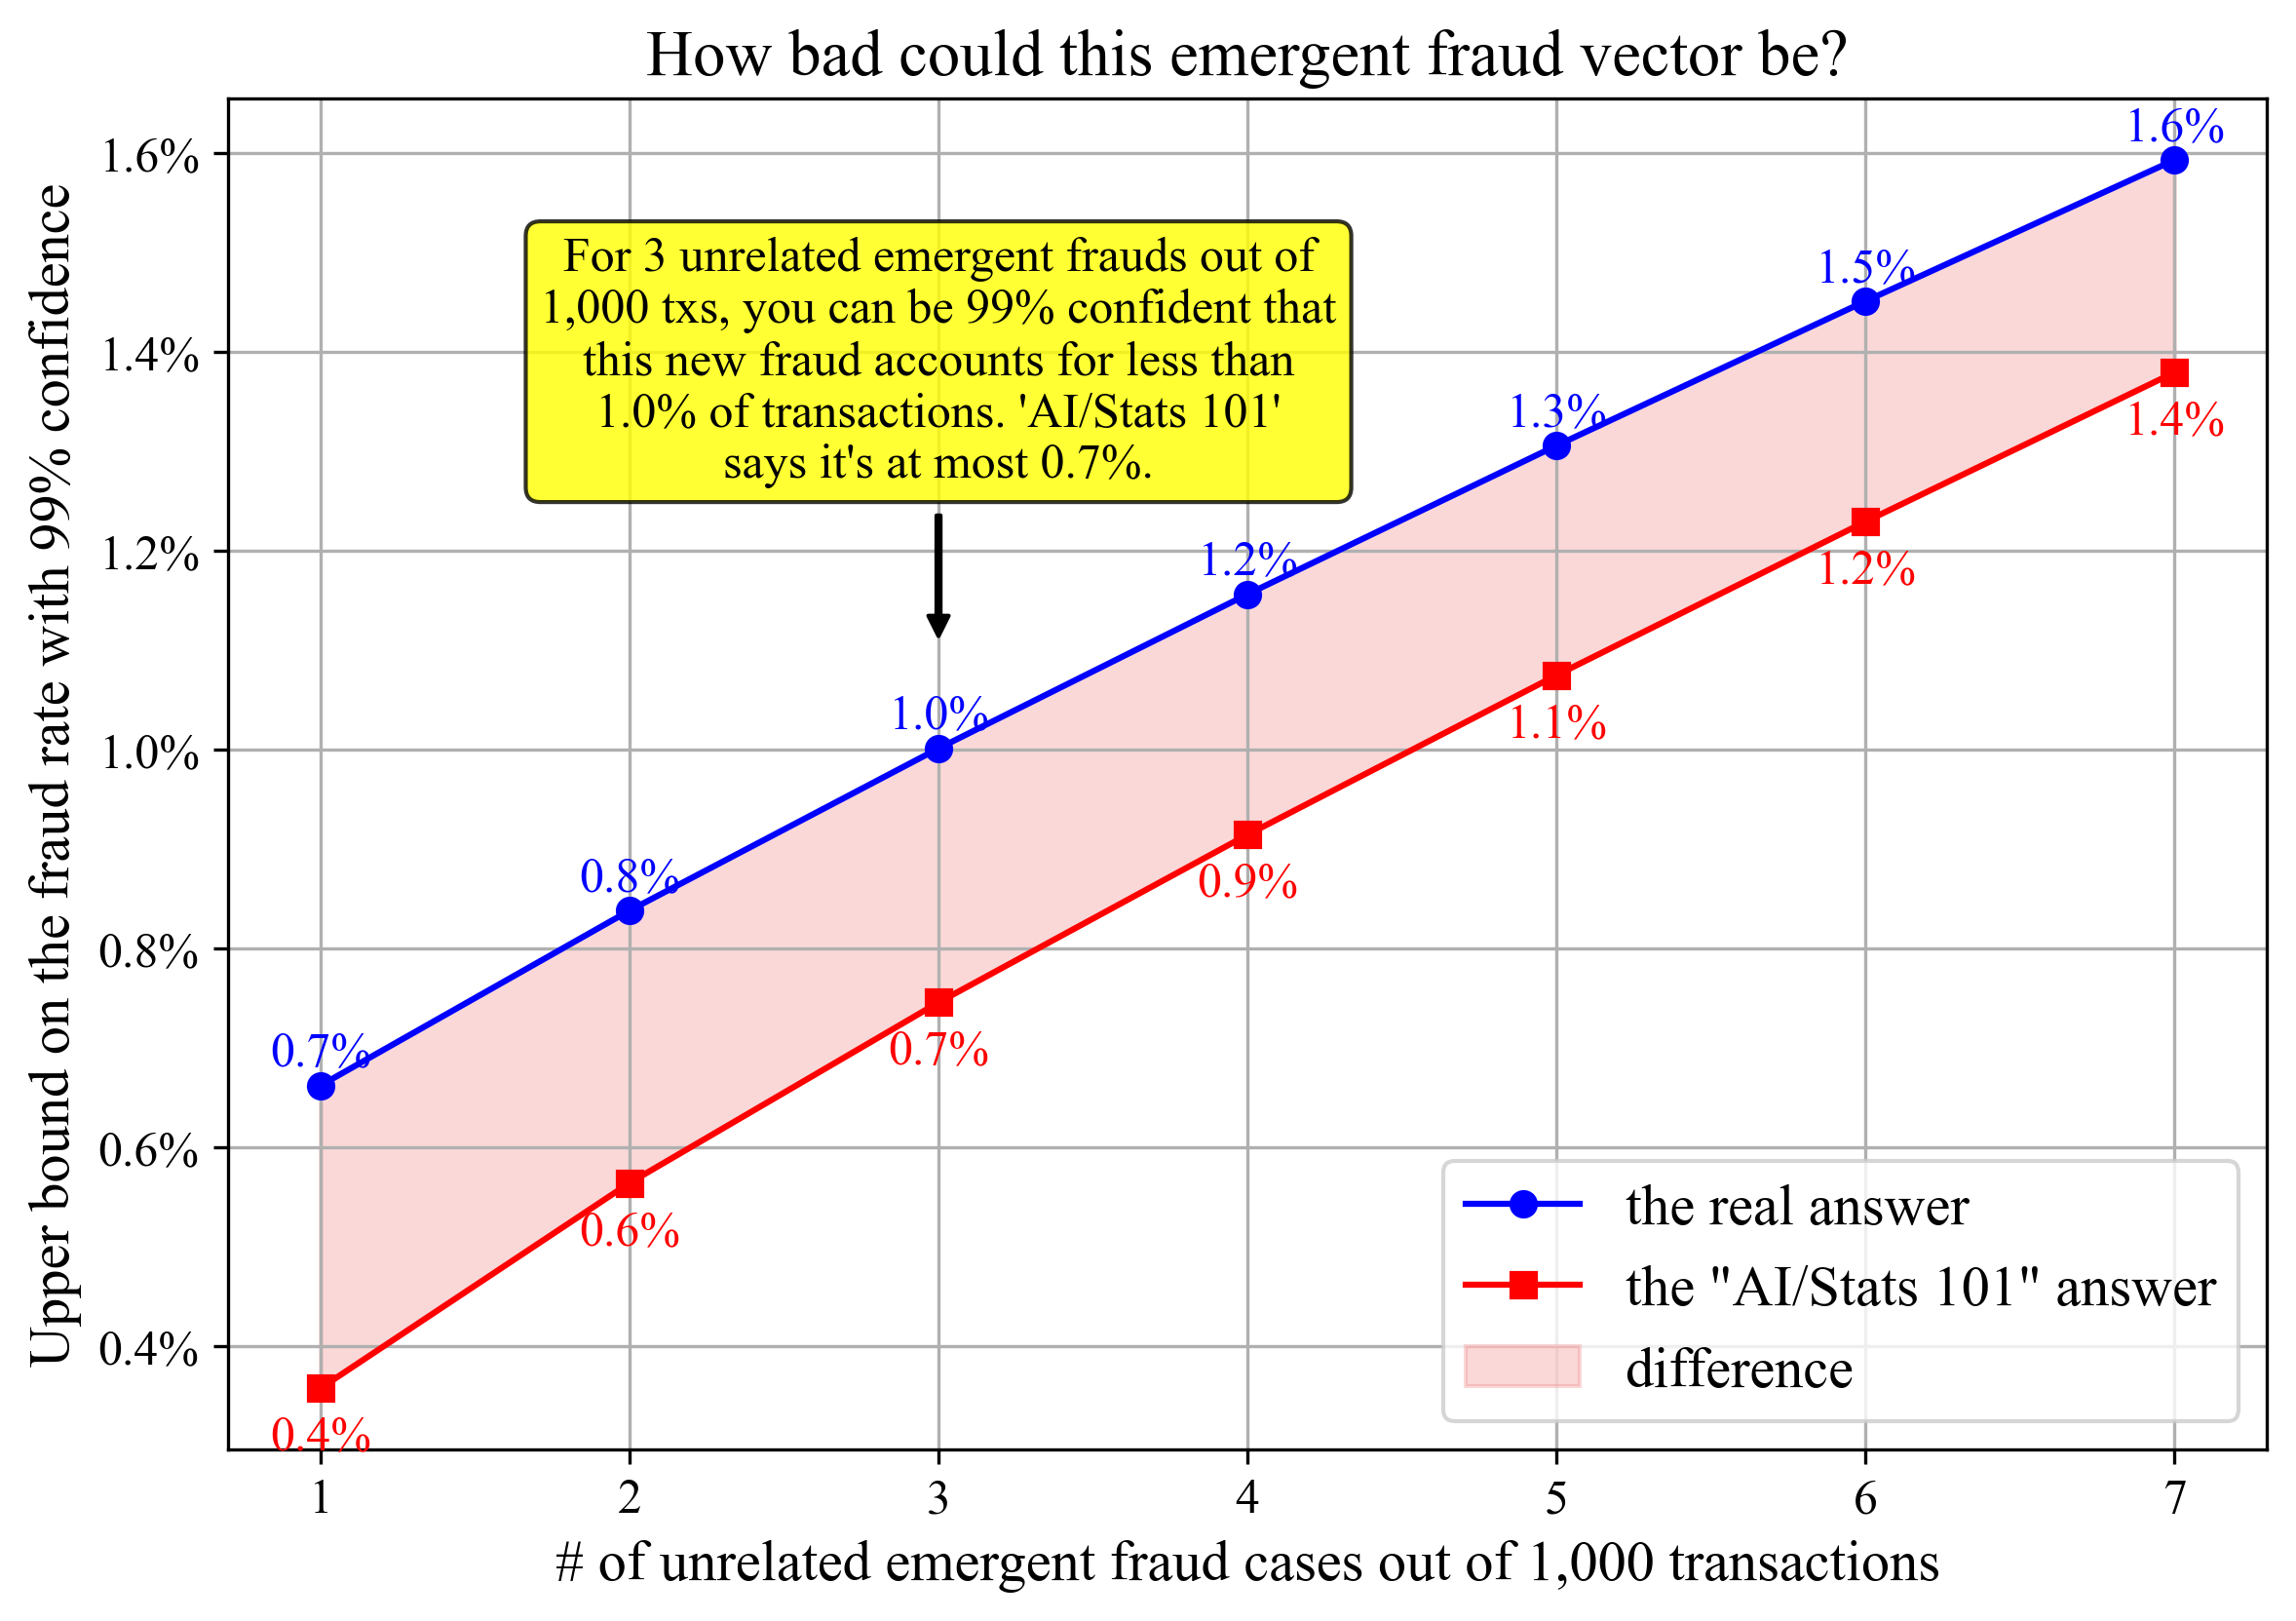

# The key things to explain

So the key things to explain here are: 

- how did I compute the real answers (the blue dots in the chart)?
- how did I compute the "AI/Stats 101" answers (the red dots in the chart)?

# How I computed the real answers (the blue dots in the chart)

We are given a confidence level $L$ and $X \sim \text{Bin}(n,p)$, where $n$ denotes the number of transactions and $p$ denotes the unknown fraud rate. We also have $k$ unrelated fraud cases among the $n$ transactions.  We assume for simplicity that the transactions constitute independent events. 

In the question posed in the LinkedIn post, $n=1,000$, $k=3$, and $L=0.99$.

We want to find the $b \in [0, 1]$ for which $p \lt b$ with $L \times 100\%$ confidence. 
The evidence we have with which to derive an upper bound on $p$ is that $X\leq k$ (i.e. we only saw 3 unrelated frauds in the post example).

Well, we are $L \times 100\%$ confident that $p \lt b$ when 
$$
P(X \leq k \mid X \sim \text{Bin}(n,b)) = 1 - L.
$$
(Going back to the post, we are 99% confident that $p \lt b$ if and only if $P(X \leq 3 \mid X \sim \text{Bin}(1000, b)) =  0.01$. 
That is, when there is only a 1% chance of seeing as few frauds as we did.)

So now we just need to find the $b \in [0, 1]$ for which 
$$
P(X \leq k \mid X \sim \text{Bin}(n,b)) = 1 - L.
$$
keeping in mind that $k$, $n$, and $L$ are known constants. That $b$ is our upper $L \times 100\%$ confidence bound.

How do we solve this equation? Consider the function $f: [0,1] \to [0,1]$ defined by
$$
f(x) := P(X \leq k \mid X \sim \text{Bin}(n,x)).
$$
This function is non-increasing, with
$$
f(0) = P(X \leq k \mid X \sim \text{Bin}(n,0)) = 1,
$$
and
$$
f(1) = P(X \leq k \mid X \sim \text{Bin}(n,1)) =
\begin{cases}
0 & \text{if } k < n \\
1 & \text{if } k = n
\end{cases}.
$$

The case $k=n$ (all transactions are fraudulent) is a degenerate case where $f(x)=1$ for all $x\in [0, 1]$ 
and the upper $L \times 100\%$ confidence bound is 100%.  Otherwise, $f(x)$ is monotonically decreasing on $[0, 1]$.
It has a single value $b$ for which $f(b)=1-L$ and we can find it by a bisection search.  (Try a first guess $g$ for $b$.
If $f(g)>1-L$, decrease your guess. If $f(g)<1-L$, increase it. Continue.)  The functions brentq or bisect in
Python's optimize module will do the trick and give you your upper $L \times 100\%$ confidence bound $b$.


For example, here's a plot of $y=f(x)$ for $k$ and $n$ as in the post ($k=3$, $n=1,000$), along with a less dramatic example that presents a more familiar sigmoid shape ($k=1$, $n=10$). 

In [ ]:

import sys
import subprocess

def install_packages():
    # Example: list your packages here
    packages = ['numpy', 'pandas', 'matplotlib']
    for p in packages:
        try:
            __import__(p)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

if 'google.colab' in sys.modules:
    install_packages()

# Binder installs packages from requirements.txt

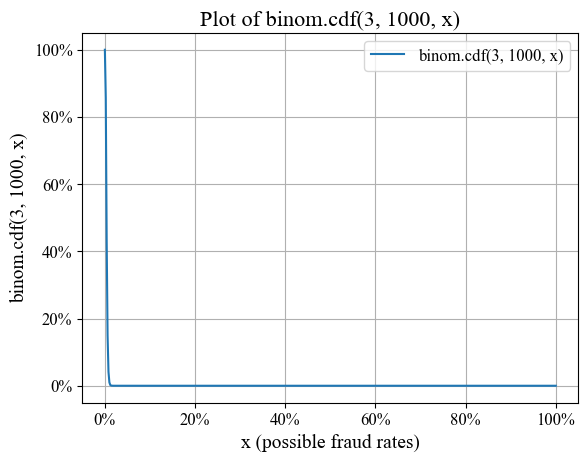

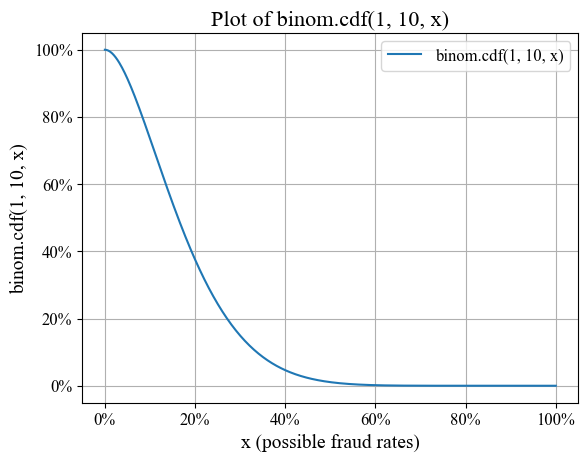

In [1]:
import os
import numpy as np
from scipy.stats import binom, norm
from scipy.optimize import brentq, bisect
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
import textwrap


if ('BINDER_SERVICE_HOST' in os.environ) or ('google.colab' in sys.modules): 
    # Running on Binder or Colab    
    plt.rcParams['font.family'] = 'DejaVu Serif'  # set available font to avoid warnings
else:
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]

plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 16,  'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12 
})

def binom_cdf_as_func_of_rate(k, n):
    """
    Plot f(x):=binom.cdf(k, n, x) for x in [0, 1] .
    
    Parameters:
    - k: integer, number of successes (0 <= k <= n)
    - n: integer, number of trials (n >= 0)
    - L: float, confidence level (0<=L<=1)
    """
    if not (0 <= k <= n):
        raise ValueError("k must be between 0 and n inclusive")
    if n <= 0:
        raise ValueError("n must be positive")

    x_values = np.linspace(0, 1, 500)
    cdf = binom.cdf(k, n, x_values)

    fig, ax = plt.subplots()
    ax.plot(x_values, cdf, label=f'binom.cdf({k}, {n}, x)')
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.xlabel('x (possible fraud rates)')
    plt.ylabel(f'binom.cdf({k}, {n}, x)')
    plt.title(f'Plot of binom.cdf({k}, {n}, x)')
    plt.legend()
    plt.grid(True)
    plt.show()

binom_cdf_as_func_of_rate(k=3, n=1000)
binom_cdf_as_func_of_rate(k=1, n=10)

Note that the function $f(x) = P(X \leq k \mid X \sim \text{Bin}(n,x))$ is decreasing on $[0,1]$, like we said. 
And, like we said, we can solve $f(x) = L$ for a given $k$, $n$, and $L$
with a bisection search, like brentq() or bisect(). That's what the next function,
upper_conf_bound, does. Remember that the solution is the upper confidence bound we seek.
(The function also handles the degenerate case where all transactions are fraudulent.)

In [2]:

def upper_conf_bound(n=1000, k=3, L=0.99):
    """
    Computes the upper Lx100% confidence bound on the failure rate 
    given k failures out of n independent identical tests.
    """
    def func(b): #func() will only be called when 0<=k<n and 0<L<1
        if b==0 or k==n:
            return -L # P(X<=k | X~Bin(n,0)) = 1 for all k>=0
        elif b==1 and k<n: 
            return 1-L # P(X<=k | X~Bin(n,1)) = 0 if k<n, and =1 if k=n
        else: # 0 <= k < n and 0 < b,L <1
            return 1 - L - binom.cdf(k, n, b)

    """
    Handling the boundary cases func(0) and func(1):
    func(0) = 1-L-binom.cdf(k,n,0)-L = -L. 
    func(1) = 1-L-binom.cdf(k,n,1)-L = 1-L if k<n, and =-L if k=n.
    For given k & n, func(b) is a non-decr function of b
    We handle the degenerate case k=n separately, and otherwise 
    apply a bisection search since func(0) and func(1) will have opposite signs."""
         
    # Use brentq method to find root in [0,1]
    if L<=0 or L>1:
        print("Confidence level invalid")
        return None  
    elif k>=n or L==1:
        return 1.0
    elif k<0:
        return 0.0 
    else: # We have 0<=k<n and 0<L<1
        upper_bound = brentq(func, 0, 1, xtol=1e-7)
        # alternative: bisect(func, 0, 1, xtol=1e-7)
        return upper_bound

n, k, L = 1000, 3, 0.99
result = upper_conf_bound(n, k, L)
print(f"The upper {L:.0%} confidence bound for k={k}, n={n} is: {result:.1%}.")


The upper 99% confidence bound for k=3, n=1000 is: 1.0%.


We can illustrate further by plotting the confidence bound on our prior confidence graph. 
To better illustrate the case of the post ($k=3$, $n=1,000$, $L=0.99$), we'll focus the $x$-axis
closer to $x=0$. 

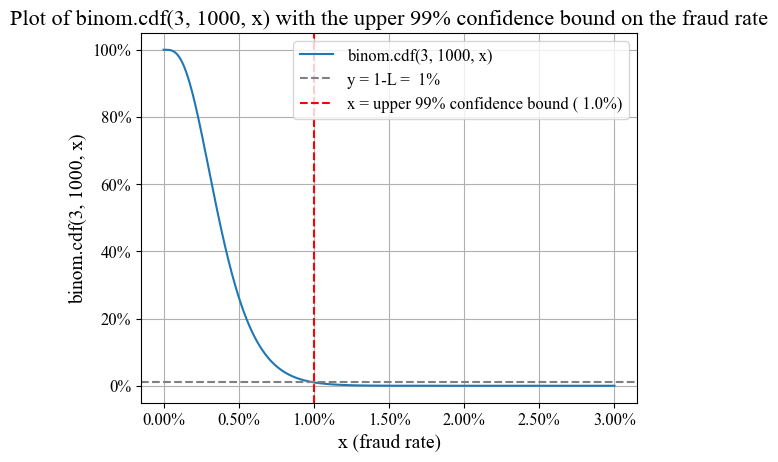

In [3]:

def plot_binom_cdf_w_conf_bd(k, n, L):
    """
    Plot binom.cdf(k, n, x) for x in [0, 1] and show the point b where 1-L=binom.cdf(b).
    
    Parameters:
    - k: integer, number of successes (0 <= k <= n)
    - n: integer, number of trials (n >= 0)
    - L: float, confidence level (0<=L<=1)
    """
    if not (0 <= k <= n):
        raise ValueError("k must be between 0 and n inclusive")
    if n <= 0:
        raise ValueError("n must be positive")
    if not (0 <= L <= 1):
        raise ValueError("L must be between 0 and 1")

    x_values = np.linspace(0, 0.03, 500)
    cdf = binom.cdf(k, n, x_values)

    b = upper_conf_bound(n, k, L)

    
    fig, ax = plt.subplots()
    ax.plot(x_values, cdf, label=f'binom.cdf({k}, {n}, x)')
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.axhline(1-L, color='grey', linestyle='--', label=f'y = 1-L = {1-L : .0%}')

    plt.axvline(b, color='red', linestyle='--', label=f'x = upper{L: .0%} confidence bound ({b: .1%})')
    plt.xlabel('x (fraud rate)')
    plt.ylabel(f'binom.cdf({k}, {n}, x)')
    plt.title(f'Plot of binom.cdf({k}, {n}, x) with the upper{L: .0%} confidence bound on the fraud rate')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_binom_cdf_w_conf_bd(k=3, n=1000, L=0.99)


With that, we have explained how we got the real answers in the post (the blue dots in the post's graph). For $k$ unrelated 
fraud cases in $n$ transactions, we applied upper_conf_bound(n, k, L) to get the $L \times 100\%$ upper confidence bound
This is the same as solving the equation
$$
P(X \leq k \mid X \sim \text{Bin}(n,x)) = 1 - L.
$$

Now on to the other thing to explain - where we got the "AI/Stats 101" answers.

# How I computed the "AI/Stats 101" answers (the blue dots in the post's chart)

In the post, we noted that AI/Stats 101 might say:

- “The fraud rate is 0.3% ± 0.4% with 99% confidence.”
- “The fraud rate is 0.3% ± 0.3%.” (because you didn’t know you could specify the confidence level and your gen AI / webpage defaults to 95%), and even:
- “Three fraud cases is too small for statistical significance.”

In the best case scenario, AI/Stats 101 recognizes your interest in 99% confidence and gives the first answer:

<p style="text-align:center;">“The fraud rate is 0.3% ± 0.4% with 99% confidence.”</p>

AI/Stats 101 is giving you the standard formula for the $L \times 100\%$ confidence interval for a proportion:
$$
\hat{p} +/- z_L \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z_L$ is the $z$-score for $L \times 100\%$ confidence:
$$
P(Z \leq z_L \mid Z \sim \text{N}(0,1)) = L + (1-L)/2 = (L+1)/2
$$

There are two issues with what AI/Stats 101 is giving you.  First, it's not exactly the confidence interval, 
but rather an approximation based on the normal distribution. Second, you don't want the confidence interval, 
you want the upper confidence bound. Here's Python for the (closest) AI/Stats 101 answer. 

In [4]:
def AI_Stats_101(k=3, n=1000, L=0.95):    
    alpha = 1 - L
    z = norm.ppf(1 - alpha/2)  # We're taking the "AI/Stats 101" answer to be the upper limit of the confidence interval
    print(f"For L={L}, z={z: .2f}")
    p_hat = k / n
    se = sqrt(p_hat * (1 - p_hat) / n)
    print(f"AI/Stats101 with L={L} says the failure rate is: {p_hat: .1%} +/- {z * se : .1%}")

AI_Stats_101(k=3, n=1000, L=0.95)
AI_Stats_101(k=3, n=1000, L=0.99)


For L=0.95, z= 1.96
AI/Stats101 with L=0.95 says the failure rate is:  0.3% +/-  0.3%
For L=0.99, z= 2.58
AI/Stats101 with L=0.99 says the failure rate is:  0.3% +/-  0.4%


With that, we have explained how we got the "AI/Stats 101" answers in the post (the red dots in the post's graph). For $k$ unrelated 
fraud cases in $n$ transactions, we applied AI_Stats_101(k, n, L) to get the $L \times 100\%$ upper confidence bound.

Finally, let's put this all together to get the plot from the post.

# The plot from the LinkedIn post

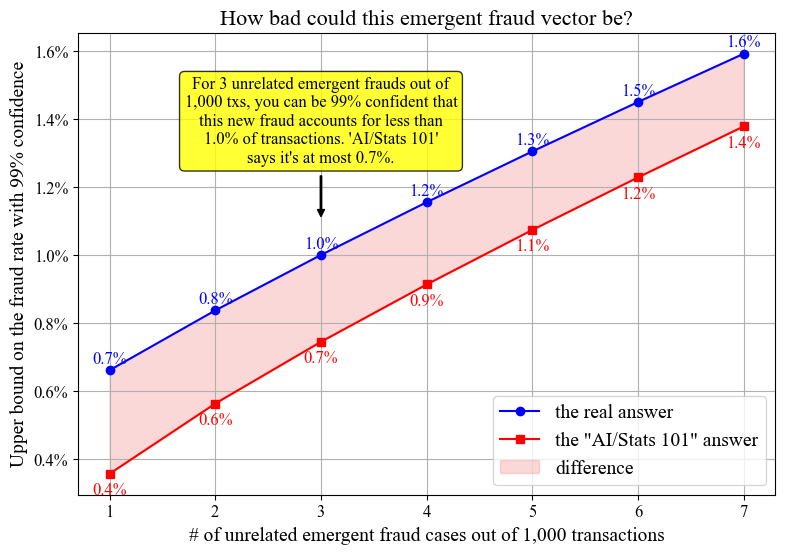

In [5]:

def plot_real_vs_AI_Stats101(n=1000, r_upper=8, L=0.95, fraud_illustration_value=3):

    """
    Plot the upper L x 100% confidence bounds for k unrelated fraud cases out of n independent transactions, 
    along with the corresponding 'AI/Stats 101' answers. Plot these for k=1,..., r_upper-1. Include an annotation 
    box illustrating the difference between the two answers for a particular value of k = fraud_illustration_value.
    
    Parameters:
    - n: integer, number of transactions (n >= 1)
    - r_upper: integer, upper end of the range on the x-axis (2 <= r_upper <= n+1)
    - L: float, confidence level (0<=L<=1)
    - fraud_illustration_value: integer, the # of frauds you want to illustrate in the annotation box (1 <= fraud_illustration_value < r_upper)
    """
    
    fraud_counts = range(1, r_upper)
    alpha = 1 - L
    z = norm.ppf(1 - alpha/2)  # We're taking the "AI/Stats 101" answer to be the upper limit of the confidence interval
    
    real_uppers = []           # the real upper confidence bounds
    AI_Stats101_uppers = []    # the 'AI/Stats 101' upper confidence bounds
    
    for k in fraud_counts:
        
        # the 'AI/Stats 101' upper confidence bound
        p_hat = k / n
        se = sqrt(p_hat * (1 - p_hat) / n)
        AI_Stats101_upper = p_hat + z * se
        AI_Stats101_uppers.append(AI_Stats101_upper)
        
        # the real upper confidence bounds
        real_upper = upper_conf_bound(n=n, k=k, L=L)
        real_uppers.append(real_upper)
    
    # Compute absolute differences
    diffs = np.abs(np.array(real_uppers) - np.array(AI_Stats101_uppers))
    
    # Fetch the real and AI/Stats 101 answers for the annotation box. 
    real_upper = real_uppers[fraud_illustration_value-1]
    ai_upper = AI_Stats101_uppers[fraud_illustration_value-1]
    
    # annotation text
    annot_text = (f"For {fraud_illustration_value} unrelated emergent frauds out of 1,000 txs, you can be {L:.0%} confident " 
        f"that this new fraud accounts for less than {real_upper:.1%} of transactions. 'AI/Stats 101' says " 
        f"it's at most {ai_upper:.1%}.")
    wrapped_text = "\n".join(textwrap.wrap(annot_text, width=40))
    
    # Plotting
    plt.figure(figsize=(9,6))
    ax = plt.gca()
    
    plt.plot(fraud_counts, real_uppers, marker='o', label='the real answer', color='blue')
    plt.plot(fraud_counts, AI_Stats101_uppers, marker='s', label='the "AI/Stats 101" answer', color='red')
    plt.fill_between(fraud_counts, real_uppers, AI_Stats101_uppers, 
                     color='lightcoral', alpha=0.3, label='difference')
    
    plt.xlabel(f'# of unrelated emergent fraud cases out of {n:,} transactions')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}'))
    plt.ylabel(f'Upper bound on the fraud rate with {L:.0%} confidence')
    
    # annotation box and arrow 
    vertical_text_x = fraud_illustration_value  
    vertical_text_y = max(real_uppers) * 0.8 

    ax.annotate(
        wrapped_text,
        xy=(fraud_illustration_value, real_upper + 0.001),
        xytext=(vertical_text_x, vertical_text_y),
        arrowprops=dict(facecolor='black', shrink=0.08, width=1, headwidth=5, headlength=5),
        fontsize=12,
        ha='center',
        fontname='Times New Roman',
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.8)
    )

    plt.title(f'How bad could this emergent fraud vector be?')
    plt.legend(fontsize=14)
    plt.grid(True)
    
    # Add value labels for real_uppers (blue dots)
    for x, y in zip(fraud_counts, real_uppers):
        ax.annotate(f'{y:.1%}', (x, y), textcoords="offset points", xytext=(0,5), ha='center', color='blue', fontsize=12)
    
    # Add value labels for AI_Stats101_uppers (red squares)
    for x, y in zip(fraud_counts, AI_Stats101_uppers):
        ax.annotate(f'{y:.1%}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=12)

    if n==1000 and L==0.99:
        plt.savefig('how-bad-could-the-emergent-fraud-be.png', dpi=300, bbox_inches='tight')
    plt.show()


#plot_real_vs_AI_Stats101(n=1000, r_upper=8, L=0.95, fraud_illustration_value=3)
plot_real_vs_AI_Stats101(n=1000, r_upper=8, L=0.99, fraud_illustration_value=3)